# Analyzing profiles
To study accuracy-resource tradeoff

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import glob
import numpy as np
import json
from collections import defaultdict
import pandas as pd
#%matplotlib notebook
from scipy.spatial import ConvexHull, convex_hull_plot_2d

PROFILE_COLUMNS = ["timestamp", "train_time", "train_loss", "train_acc", "train_num_batches",
                            "val_time", "val_loss", "val_acc", "val_num_batches",
                  "test_time", "test_loss", "test_acc", "test_num_batches"]

In [2]:
results_root = '/home/romilb/research/msr/results/profiling/20200118_1252'
result_dir = '/home/romilb/research/msr/results/profiling/20200118_1252/meta/'
profiles_dir = os.path.join(result_dir, "profiles")
os.makedirs(result_dir, exist_ok=True)
os.makedirs(profiles_dir, exist_ok=True)
city_names = os.listdir(results_root)
if "meta" in city_names:
    city_names.remove("meta")
if "plots" in city_names:
    city_names.remove("plots")
print(city_names)

['zurich', 'stuttgart', 'darmstadt', 'dusseldorf', 'monchengladbach', 'aachen', 'tubingen', 'bochum', 'bremen', 'cologne', 'ulm', 'jena']


In [3]:
# profile: [hparamid_epochs, start_acc, end_acc, resource_time]
def get_data(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    task_ids, accs = zip(*data['test_acc'].items())
    task_ids = [int(x) for x in task_ids]
    return task_ids, accs

def get_profile(json_path):
    with open(json_path) as json_file:
        data = json.load(json_file)
    profile_task_map = {}
    for taskid, profile_list in data.items():
        prof = pd.DataFrame(data[taskid], columns=PROFILE_COLUMNS)
        prof['total_cost'] = prof['train_time'].cumsum() + prof['test_time']
        prof['delta_acc_cost'] = prof['test_acc']/prof['total_cost']
        profile_task_map[taskid] = prof
    return profile_task_map

def read_json_file(json_path):
    with open(json_path) as json_file:
        return json.load(json_file)
    
def get_subprofile_epochids(subprofile_json_path):
    data = read_json_file(subprofile_json_path)
    subprofiles_dict = list(data.values())[0]
    return [int(x) for x in subprofiles_dict.keys()]

   
def get_subprofile_default_accs(subprofile_json_path):
    data = read_json_file(subprofile_json_path)
    return list(data["0"].values())[0] # This is taskwise accuracy of untrained model

def get_top5(taskwise_acc_dict, taskid, topk=5):
    data = taskwise_acc_dict[taskid]
    hp_ids = sorted(data, key=data.get, reverse=True)[:topk]
    return hp_ids, [data[i] for i in hp_ids]

# Aggregate across tasks

zurich
stuttgart
darmstadt
dusseldorf
monchengladbach
aachen
tubingen
bochum
bremen
cologne
ulm
jena


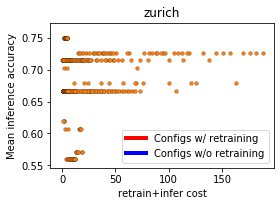

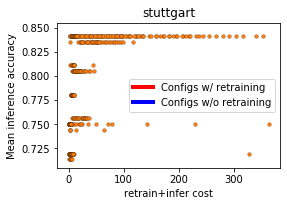

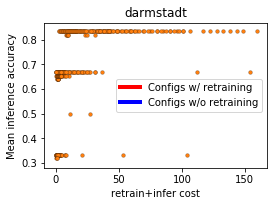

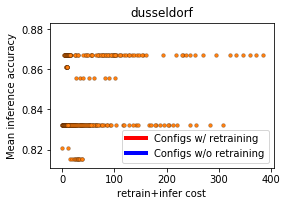

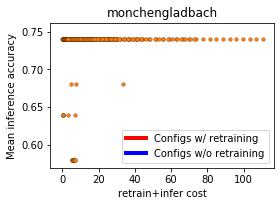

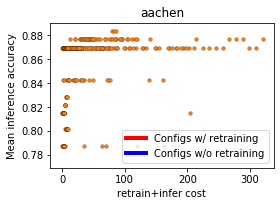

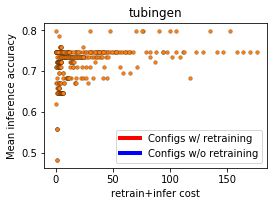

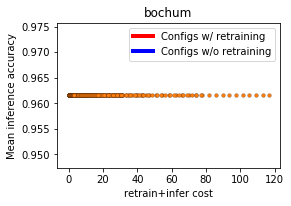

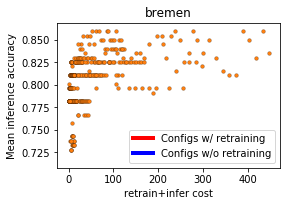

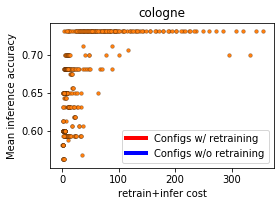

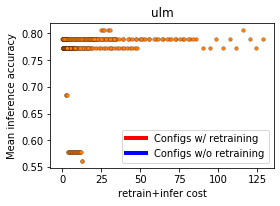

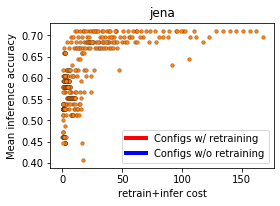

In [4]:
# Generate profiles
from matplotlib.lines import Line2D
for city in city_names:
    plt.figure(figsize=[4,2*4/3])
    print(city)
    city_path = os.path.join(results_root, city)

    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    profile_files = (glob.glob(city_path + "/*_profile.json"))
    hyperparam_ids = [os.path.basename(x).split('_profile.json')[0] for x in profile_files]

    plot_data_x_baselines = []
    plot_data_y_baselines = []
    
    all_hp_data_cost = []
    all_hp_data_acc = []
    
    for hp_id in hyperparam_ids:
        all_task_profiles = []
        profile_path = os.path.join(city_path, '{}_profile.json'.format(hp_id))
        subprofile_path = os.path.join(city_path, '{}_subprofile_test.json'.format(hp_id))
        
        for TASK_ID in [str(x) for x in range(1,2)]:
            profile = get_profile(profile_path)[TASK_ID]
            all_task_profiles.append(profile)
            
        all_tasks_data = pd.concat(all_task_profiles)
        all_tasks_data_mean = all_tasks_data.groupby(level=0).mean()
        all_hp_data_cost.extend(all_tasks_data_mean['total_cost'])
        all_hp_data_acc.extend(all_tasks_data_mean['test_acc'])
        
        acc = all_tasks_data_mean.loc[0]['test_acc']
        cost = all_tasks_data_mean.loc[0]['total_cost']
        plot_data_x_baselines.append(cost)
        plot_data_y_baselines.append(acc)
        #plt.plot(profile['delta_acc_cost'], label=hp_id)
        plt.scatter(all_tasks_data_mean['total_cost'], all_tasks_data_mean['test_acc'], color='C1',
                    edgecolors = 'black', linewidths=0.2, s=14)

    
    
#     hull_data = np.array([all_hp_data_cost, all_hp_data_acc]).T
#     hull = ConvexHull(hull_data)
#     for simplex in hull.simplices[2:-2]:
#         plt.plot(hull_data[simplex, 0], hull_data[simplex, 1], 'k-')
        
    #plt.scatter(plot_data_x_baselines, plot_data_y_baselines, color='blue', label='Configs without retraining')
    plt.xlabel('retrain+infer cost')
    plt.ylabel('Mean inference accuracy')
    plt.title(city)
    
    custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

    
    plt.legend(custom_lines, ['Configs w/ retraining', 'Configs w/o retraining'])    
    plt.savefig('{}.pdf'.format(city))
            # Get first epoch for baseline
#             acc = profile.loc[0]['test_acc']
#             cost = profile.loc[0]['total_cost']
#             plot_data_x_baselines.append(cost)
#             plot_data_y_baselines.append(acc)
#             #plt.plot(profile['delta_acc_cost'], label=hp_id)
#             plt.scatter(profile['total_cost'], profile['test_acc'], color='red')
        

In [42]:
x=pd.concat(all_profiles)

In [56]:
len(all_profiles)

9

In [53]:
foo = x.groupby(level=0).mean()

In [54]:
foo

,timestamp,train_time,train_loss,train_acc,train_num_batches,val_time,val_loss,val_acc,val_num_batches,test_time,test_loss,test_acc,test_num_batches,total_cost,delta_acc_cost
0,1.579385e+09,1.998668,1.070080,0.627359,650.222222,0.887521,1.015338,0.645218,512.555556,0.145990,1.010306,0.640432,84.0,2.144658,0.955352
1,1.579385e+09,2.003229,1.001796,0.650754,650.222222,0.890542,0.966366,0.662068,512.555556,0.146046,0.978923,0.657738,84.0,4.147942,0.581763
2,1.579385e+09,2.003279,0.954152,0.664597,650.222222,0.890760,0.938534,0.670342,512.555556,0.146310,0.964884,0.655423,84.0,6.151486,0.414442
3,1.579385e+09,2.003301,0.920752,0.674867,650.222222,0.890300,0.916370,0.677119,512.555556,0.146153,0.954479,0.660604,84.0,8.154630,0.324830
4,1.579385e+09,2.003882,0.893572,0.683774,650.222222,0.890469,0.895430,0.684202,512.555556,0.146222,0.948222,0.666777,84.0,10.158581,0.267961
5,1.579385e+09,2.004386,0.872553,0.688108,650.222222,0.891267,0.872781,0.691700,512.555556,0.145952,0.947246,0.661376,84.0,12.162697,0.222948
6,1.579385e+09,2.004524,0.850811,0.692164,650.222222,0.892166,0.854062,0.694769,512.555556,0.146088,0.943894,0.661706,84.0,14.167357,0.194453
7,1.579386e+09,2.004822,0.831397,0.698085,650.222222,0.891268,0.834598,0.699480,512.555556,0.146247,0.936204,0.663250,84.0,16.172339,0.172341
8,1.579386e+09,2.004621,0.812776,0.704472,650.222222,0.891383,0.817526,0.704388,512.555556,0.146362,0.927703,0.667108,84.0,18.177075,0.155944
9,1.579386e+09,2.004212,0.798109,0.709397,650.222222,0.890687,0.803530,0.707971,512.555556,0.146457,0.921923,0.668100,84.0,20.181382,0.142649


# Alternative:

In [4]:
data_root = '/home/romilb/research/msr/results/profiling/20200110_0807'#20200110_0643'#20200102_2037'
result_dir = '/home/romilb/research/msr/results/motivation/camera_ready/acc_profile'
os.makedirs(result_dir, exist_ok=True)

city_names = os.listdir(data_root)
if "plots" in city_names:
    city_names.remove("plots")
if "plot" in city_names:
    city_names.remove("plot")
if "plot_compare" in city_names:
    city_names.remove("plot_compare")
print(city_names)

['zurich', 'stuttgart', 'darmstadt', 'dusseldorf', 'monchengladbach', 'aachen', 'tubingen', 'bochum', 'bremen', 'meta', 'cologne', 'ulm', 'jena', 'strasbourg', 'hamburg', 'krefeld', 'weimar']


In [5]:
aspect = 1.4
height = 2.5
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}

params = {'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

/home/romilb/research/msr/results/motivation/camera_ready/acc_profile/cologne.pdf
cologne: min time 2.588111639022827, max time 505.9784481525421. Ratio: 195.50101337343406
/home/romilb/research/msr/results/motivation/camera_ready/acc_profile/jena.pdf
jena: min time 1.1990432739257812, max time 241.62330651283264. Ratio: 201.51341637715464
/home/romilb/research/msr/results/motivation/camera_ready/acc_profile/weimar.pdf
weimar: min time 1.2611172199249268, max time 250.79605746269226. Ratio: 198.86815713897073


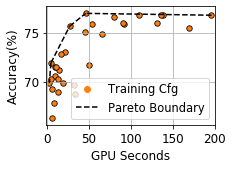

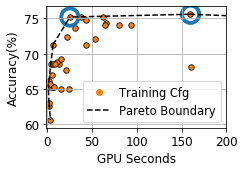

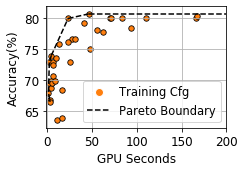

In [22]:
metric_to_plot = 'test_acc'
hyp_param_to_plot = 'num_epochs'
NUM_PROFILES_PER_CURVE = 3
TASK = "2"
num_tasks=3

cities_to_plot = city_names
cities_to_plot = ['cologne', 'jena', 'weimar']
#cities_to_plot = ['jena']
for city in cities_to_plot:
    jobs = []
    plt.figure(figsize=[height*aspect,height])

    # Plot full data sample data
    city_path = os.path.join(data_root, city)
    retrain_result_files = (glob.glob(city_path + "/*_retraining_result.json"))
    hyperparam_ids = sorted([os.path.basename(x).split('_retraining_result.json')[0] for x in retrain_result_files],
                           key=int)

    # Read hyperparameter map
    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    
    constant_hparam_dict = {}
    for hp_id in hyperparam_ids:
        hparams = hyp_map[hp_id]
        
        profile = get_profile(os.path.join(city_path, '{}_profile.json'.format(hp_id)))[TASK]
        num_epochs = len(profile['train_time'])
        
        time_elapsed = np.cumsum(profile['train_time'])
        metric = profile[metric_to_plot]
        
        skip = int(num_epochs/NUM_PROFILES_PER_CURVE)
        for i in range(0,num_tasks):
            idx = skip*(i+1)-1
            job = {'train_time': time_elapsed[idx], metric_to_plot: metric[idx]}
            jobs.append(job)
        
    time_data = [j['train_time'] for j in jobs] 
    acc_data = [j[metric_to_plot]*100 for j in jobs]
    
    if city == 'jena':
        time_data.pop(22)
        acc_data.pop(22)
        
        # Coords of circles:
        x1=25.346429586410522
        y1=75.19685039370079
        
        x2=160.11714506149292
        y2=75.59055118110236
        
        
        circle1 = plt.scatter(x1, y1, s=300, facecolors='none', edgecolors='C0', linewidths=3.5)
        circle2 = plt.scatter(x2, y2, s=300, facecolors='none', edgecolors='C0', linewidths=3.5)
        ax=plt.gca()
        ax.add_artist(circle1)
        ax.add_artist(circle2)

    
    
    hull_data = np.array([time_data, acc_data]).T
    hull = ConvexHull(hull_data)
    simplexes = {'weimar': np.concatenate([hull.simplices[0:3], hull.simplices[6:]]),
                 'cologne': hull.simplices[2:-1],
                 'jena': np.concatenate([hull.simplices[0:2], hull.simplices[4:]]),
                 'FILL THIS IN': None}
    for simplex in simplexes[city]:
        plt.plot(hull_data[simplex, 0], hull_data[simplex, 1], 'k--')
        
    plt.scatter(time_data, acc_data, color='C1',
                    edgecolors = 'black', linewidths=0.8, s=30, label='Training Configuration')
    
    legend_elements = [Line2D([0], [0], markerfacecolor='C1', marker='o',
                            color = 'w', linewidth=0.8, markersize=8, label='Training Cfg'),
                       Line2D([0], [0], color='black', ls='--', label='Pareto Boundary')]
    
    leg = plt.legend(handles=legend_elements, loc='lower right', prop={'size': 11.5})
        
    #plt.title("Profiles: {}".format(city, metric_to_plot))
    plt.ylabel("Accuracy(%)")
    plt.xlabel("GPU Seconds")
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    #plt.ylim([55,90])
    plt.xlim([-1,200])
    plt.xticks(range(0,201,50))
    plt.tight_layout()
    save_path = os.path.join(result_dir, '{}.pdf'.format(city))
    plt.savefig(save_path)
    print(save_path)
    print("{}: min time {}, max time {}. Ratio: {}".format(
        city, min(time_data), max(time_data), max(time_data)/min(time_data) ))

In [41]:
acc_data[time_data.index(159.11714506149292)]

75.59055118110236

# Plot hyperparam only

In [15]:
profile

,timestamp,train_time,train_loss,train_acc,train_num_batches,val_time,val_loss,val_acc,val_num_batches,test_time,test_loss,test_acc,test_num_batches,total_cost,delta_acc_cost
0,1.578711e+09,8.010288,0.847037,0.705128,1170,2.218953,0.829177,0.690531,866,0.647471,0.878888,0.618110,254,8.657758,0.071394
1,1.578711e+09,8.057599,0.690697,0.755556,1170,2.224224,0.710349,0.735566,866,0.648772,0.753347,0.704724,254,16.716658,0.042157
2,1.578711e+09,8.054267,0.652642,0.769231,1170,2.223514,0.693987,0.759815,866,0.653278,0.743157,0.748031,254,24.775431,0.030192
3,1.578711e+09,8.064562,0.645903,0.762393,1170,2.228430,0.680190,0.748268,866,0.653751,0.721993,0.732283,254,32.840466,0.022298
4,1.578711e+09,8.060679,0.627880,0.761538,1170,2.228439,0.643465,0.759815,866,0.649835,0.662725,0.755906,254,40.897228,0.018483
5,1.578711e+09,8.062942,0.610597,0.767521,1170,2.230320,0.723870,0.728637,866,0.648264,0.736978,0.716535,254,48.958599,0.014636
6,1.578711e+09,8.056855,0.595919,0.770085,1170,2.226153,0.693033,0.742494,866,0.651845,0.722044,0.712598,254,57.019035,0.012498
7,1.578711e+09,8.058886,0.588210,0.773504,1170,2.228785,0.657433,0.758661,866,0.647770,0.682665,0.751969,254,65.073847,0.011556
8,1.578711e+09,8.060784,0.604660,0.752991,1170,2.227336,0.630673,0.760970,866,0.654826,0.675152,0.744094,254,73.141686,0.010173
9,1.578711e+09,8.061557,0.600339,0.765812,1170,2.228765,0.722187,0.740185,866,0.654635,0.724183,0.740157,254,81.203052,0.009115


/home/romilb/research/msr/results/motivation/camera_ready/acc_profile/jena.pdf
jena: min time 1.1990432739257812, max time 241.62330651283264. Ratio: 201.51341637715464


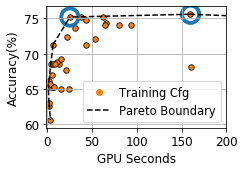

In [32]:
metric_to_plot = 'test_acc'
hyp_param_to_plot = 'num_epochs'
NUM_PROFILES_PER_CURVE = 3
TASK = "2"
num_tasks=3

cities_to_plot = city_names
#cities_to_plot = ['cologne', 'jena', 'weimar']
cities_to_plot = ['jena']
for city in cities_to_plot:
    jobs = []
    plt.figure(figsize=[height*aspect,height])

    # Plot full data sample data
    city_path = os.path.join(data_root, city)
    retrain_result_files = (glob.glob(city_path + "/*_retraining_result.json"))
    hyperparam_ids = sorted([os.path.basename(x).split('_retraining_result.json')[0] for x in retrain_result_files],
                           key=int)

    # Read hyperparameter map
    with open(os.path.join(city_path, 'hyp_map.json')) as f:
        hyp_map = json.load(f)
    
    constant_hparam_dict = {}
    for hp_id in hyperparam_ids:
        hparams = hyp_map[hp_id]
        
        profile = get_profile(os.path.join(city_path, '{}_profile.json'.format(hp_id)))[TASK]
        num_epochs = len(profile['train_time'])
        
        time_elapsed = np.cumsum(profile['train_time'])
        metric = profile[metric_to_plot]
        
        skip = int(num_epochs/NUM_PROFILES_PER_CURVE)
        for i in range(0,num_tasks):
            idx = skip*(i+1)-1
            job = {'train_time': time_elapsed[idx], metric_to_plot: metric[idx]}
            jobs.append(job)
        
    time_data = [j['train_time'] for j in jobs] 
    acc_data = [j[metric_to_plot]*100 for j in jobs]
    
    if city == 'jena':
        time_data.pop(22)
        acc_data.pop(22)
        
        # Coords of circles:
        x1=25.346429586410522
        y1=75.19685039370079
        
        x2=160.11714506149292
        y2=75.59055118110236
        
        
        circle1 = plt.scatter(x1, y1, s=300, facecolors='none', edgecolors='C0', linewidths=3.5)
        circle2 = plt.scatter(x2, y2, s=300, facecolors='none', edgecolors='C0', linewidths=3.5)
        ax=plt.gca()
        ax.add_artist(circle1)
        ax.add_artist(circle2)

    
    
    hull_data = np.array([time_data, acc_data]).T
    hull = ConvexHull(hull_data)
    simplexes = {'weimar': np.concatenate([hull.simplices[0:3], hull.simplices[6:]]),
                 'cologne': hull.simplices[2:-1],
                 'jena': np.concatenate([hull.simplices[0:2], hull.simplices[4:]]),
                 'FILL THIS IN': None}
    for simplex in simplexes[city]:
        plt.plot(hull_data[simplex, 0], hull_data[simplex, 1], 'k--')
        
    plt.scatter(time_data, acc_data, color='C1',
                    edgecolors = 'black', linewidths=0.8, s=30, label='Training Configuration')
    
    legend_elements = [Line2D([0], [0], markerfacecolor='C1', marker='o',
                            color = 'w', linewidth=0.8, markersize=8, label='Training Cfg'),
                       Line2D([0], [0], color='black', ls='--', label='Pareto Boundary')]
    
    leg = plt.legend(handles=legend_elements, loc='lower right', prop={'size': 11.5})
        
    #plt.title("Profiles: {}".format(city, metric_to_plot))
    plt.ylabel("Accuracy(%)")
    plt.xlabel("GPU Seconds")
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    #plt.ylim([55,90])
    plt.xlim([-1,200])
    plt.xticks(range(0,201,50))
    plt.tight_layout()
    save_path = os.path.join(result_dir, '{}.pdf'.format(city))
    plt.savefig(save_path)
    print(save_path)
    print("{}: min time {}, max time {}. Ratio: {}".format(
        city, min(time_data), max(time_data), max(time_data)/min(time_data) ))

In [44]:
s = pd.DataFrame(list(zip(time_data, acc_data)), columns=['time', 'acc'])

In [45]:
s

,time,acc
0,1.199043,65.354331
1,2.396270,62.598425
2,3.592697,60.629921
3,12.674207,68.503937
4,25.346430,75.196850
5,38.096725,75.196850
6,2.142424,66.141732
7,4.275722,68.503937
8,6.410160,71.259843
9,21.932508,72.440945


In [67]:
subsampling = [2,20,27]
hiddenlayer = [23, 16, 32]

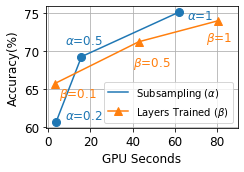

In [125]:

fig = plt.figure(figsize=[height*aspect,height])
ax = plt.gca()
s.loc[subsampling].plot(x='time', y='acc', kind='line', ax=ax, marker='o', markersize=8, label=r'Subsampling ($\alpha$)')
s.loc[hiddenlayer].plot(x='time', y='acc', kind='line', ax=ax, marker='^', markersize=8, label=r'Layers Trained ($\beta$)')
plt.ylabel("Accuracy(%)")
plt.xlabel("GPU Seconds")
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)

plt.text(8, 61, r"$\alpha$=0.2", color='C0', fontsize=12)
plt.text(8, 71, r"$\alpha$=0.5", color='C0', fontsize=12)
plt.text(66, 74.3, r"$\alpha$=1", color='C0', fontsize=12)

plt.text(5, 64, r"$\beta$=0.1", color='C1', fontsize=12)
plt.text(40, 68, r"$\beta$=0.5", color='C1', fontsize=12)
plt.text(75, 71.3, r"$\beta$=1", color='C1', fontsize=12)

#plt.ylim([55,90])
plt.xlim([-1,90])
#plt.xticks(range(0,201,50))
plt.tight_layout()

save_path = os.path.join(result_dir, '{}_hypparams.pdf'.format(city))
plt.savefig(save_path)

In [124]:
result_dir

'/home/romilb/research/msr/results/motivation/camera_ready/acc_profile'

In [82]:
s.loc[hiddenlayer]

,time,acc
23,3.063593,65.748031
16,42.986372,71.259843
32,80.548417,74.015748
